In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torchqc.states import QuantumState
from torchqc.common_functions import get_density_matrix, fidelity
from torchqc.operators import DynamicOperator
from torchqc.common_matrices import annihilation, creation, eye, sigmaMinus, sigmaPlus
from torchqc.dynamics import TDSE
from torchqc.tensor_product import tensor_product_ops, tensor_product_states, partial_trace

torch.manual_seed(1989)

* Define Neural Network

In [2]:
Ωo = 1
max_control = 1.

class NeuralNet(nn.Module):
    def __init__(self, hidden_size, nb_hidden_layers = 2, input_size = 1, output_size = 1, activation_fn = nn.Tanh):
        super(NeuralNet, self).__init__()

        self.nb_hidden_layers = nb_hidden_layers
        self.hidden_layers = []
        self.hidden_act_layers = []

        # input layer
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.relu_input = activation_fn()

        # hidden layers
        for layer in range(nb_hidden_layers):
            new_layer = nn.Linear(hidden_size, hidden_size)
            self.hidden_layers.append(new_layer)
            self.hidden_act_layers.append(activation_fn())
            
            # hidden layer parameters should be registered
            self.register_parameter(f"weights_{layer}", new_layer.weight)
            self.register_parameter(f"bias_{layer}", new_layer.bias)

        # output layer
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.input_layer(x)
        out = self.relu_input(out)

        for layer in range(self.nb_hidden_layers):
            out = self.hidden_layers[layer](out)
            out = self.hidden_act_layers[layer](out)

        out = self.output_layer(out)
        out = torch.clip(input=out, min=-max_control, max=max_control)

        return out

In [3]:
class Sin(nn.Module):
    """The sin activation function.
    """

    def __init__(self):
        """Initializer method.
        """
        super().__init__()

    def forward(self, input_):
        return torch.sin(input_)

* Start from basis state $\ket{0}$

In [4]:
N = 10 # resonator modes
n = 2
# tensor product of two qubits and a resonator mode
total_dims = n * n * n * N

qubit_states_basis = QuantumState.basis(n)
resonator_basis_states = QuantumState.basis(N)

qubit1_state = qubit_states_basis[0]
qubit2_state = qubit_states_basis[1]
qubit3_state = qubit_states_basis[0]
resonator_state = resonator_basis_states[0]

initial_state = tensor_product_states(qubit1_state, qubit2_state, qubit3_state, resonator_state)
target_state = (1 / np.sqrt(2)) * (tensor_product_states(qubit_states_basis[0], qubit_states_basis[0], qubit_states_basis[0]) + tensor_product_states(qubit_states_basis[1], qubit_states_basis[1], qubit_states_basis[1]))
target_state = get_density_matrix(target_state)

* Simulate dynamics with TDSE

In [5]:
τ = 1
T = 8 * τ
Dt = 0.1 * τ
time = np.arange(0, T, Dt, dtype = np.float32)
time_tensor = torch.from_numpy(time).reshape(len(time), 1)

In [6]:
BBNN = NeuralNet(hidden_size=150, input_size=1, output_size=4, nb_hidden_layers=4, activation_fn=Sin)

* Construct Hamiltonian and define loss function

$H = \sum_{j=1}^3 g_j(t) (a^\dagger \sigma^-_j + a \sigma^+_j) + \xi(t) (a + a^\dagger) $

In [7]:
def quantum_simulation(u_pred):
    a_dagger = creation(N)
    a = annihilation(N)
    sm = sigmaMinus()
    sp = sigmaPlus()

    g1 = u_pred[:, 0:1]
    g1.unsqueeze_(-1)
    g1.expand(len(time), total_dims, total_dims)

    g2 = u_pred[:, 1:2]
    g2.unsqueeze_(-1)
    g2.expand(len(time), total_dims, total_dims)

    g3 = u_pred[:, 2:3]
    g3.unsqueeze_(-1)
    g3.expand(len(time), total_dims, total_dims)

    ξ = u_pred[:, 3:4]
    ξ.unsqueeze_(-1)
    ξ.expand(len(time), total_dims, total_dims)

    H1 = g1 * (tensor_product_ops(sm, eye(n), eye(n), a_dagger) + tensor_product_ops(sp, eye(n), eye(n), a)) \
    + g2 * (tensor_product_ops(eye(n), sm, eye(n), a_dagger) + tensor_product_ops(eye(n), sp, eye(n), a)) \
        + g3 * (tensor_product_ops(eye(n), eye(n), sm, a_dagger) + tensor_product_ops(eye(n), eye(n), sp, a))

    H2 = ξ * tensor_product_ops(eye(n), eye(n), eye(n), a_dagger + a)

    H = H1 + H2

    hamiltonian = DynamicOperator(total_dims, H.matrix)
    states = TDSE(initial_state, hamiltonian, time, Dt)

    return states

def criterion_fidelity_custom(u_pred):
    states = quantum_simulation(u_pred)
    
    achieved_state = states[-1]
    achieved_rho = get_density_matrix(achieved_state)
    reduced_achieved_state = partial_trace(achieved_rho, [3])

    infidelity = 1 - fidelity(reduced_achieved_state, target_state)

    return infidelity

* Training loop of the Deep NN using the defined objective function

In [8]:
def training(learning_rate=1e-3, iterations=100):
    losses = []
    loss_threshold = 1e-4

    BBNN.train()

    optimizer = torch.optim.Adam(BBNN.parameters(), lr=learning_rate)
    print_interval = 10
    num_epochs = 0

    # while loss_float >= loss_threshold:
    for iter in range(iterations):
        # forward pass
        u_pred = BBNN(time_tensor)

        # calculate loss based on controls that produced by the nn
        loss = criterion_fidelity_custom(u_pred)
        losses.append(loss.detach().numpy())

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if num_epochs % print_interval == 0:
            print("Epoch = ", num_epochs, ", Infidelity = ", loss.clone().detach().numpy())

        num_epochs += 1

        if losses[-1] < loss_threshold:
            break

In [9]:
training(1e-3, 500)

Epoch =  0 , Infidelity =  0.8814894412923834
Epoch =  10 , Infidelity =  0.8794212767667959
Epoch =  20 , Infidelity =  0.7714553110447451
Epoch =  30 , Infidelity =  0.4100416360960438
Epoch =  40 , Infidelity =  0.28754517297050364
Epoch =  50 , Infidelity =  0.2703947023113137
Epoch =  60 , Infidelity =  0.2563390359606338
Epoch =  70 , Infidelity =  0.24235797780036283
Epoch =  80 , Infidelity =  0.23237617538934763
Epoch =  90 , Infidelity =  0.26986461278203633
Epoch =  100 , Infidelity =  0.233370166248406
Epoch =  110 , Infidelity =  0.21761649468289523
Epoch =  120 , Infidelity =  0.21228017366011098
Epoch =  130 , Infidelity =  0.21722664148939064
Epoch =  140 , Infidelity =  0.23920480356207918
Epoch =  150 , Infidelity =  0.2146905283401599
Epoch =  160 , Infidelity =  0.15938769020491006
Epoch =  170 , Infidelity =  0.1497834809802041
Epoch =  180 , Infidelity =  0.13946417474495454
Epoch =  190 , Infidelity =  0.18202759250379974
Epoch =  200 , Infidelity =  0.1474731240

In [10]:
training(1e-4, 500)

Epoch =  0 , Infidelity =  0.03187872953155679
Epoch =  10 , Infidelity =  0.05156408137010149
Epoch =  20 , Infidelity =  0.04077110780741422
Epoch =  30 , Infidelity =  0.033889368986602664
Epoch =  40 , Infidelity =  0.03126827422155665
Epoch =  50 , Infidelity =  0.030261434940901943
Epoch =  60 , Infidelity =  0.029715427029178287
Epoch =  70 , Infidelity =  0.029560795290398123
Epoch =  80 , Infidelity =  0.029518455728895887
Epoch =  90 , Infidelity =  0.02942502742274522
Epoch =  100 , Infidelity =  0.02935716956100176
Epoch =  110 , Infidelity =  0.029281784278780365
Epoch =  120 , Infidelity =  0.029204471040996438
Epoch =  130 , Infidelity =  0.029124550296427465
Epoch =  140 , Infidelity =  0.029040948576657954
Epoch =  150 , Infidelity =  0.028953503520455337
Epoch =  160 , Infidelity =  0.028862084603573313
Epoch =  170 , Infidelity =  0.028766529510008798
Epoch =  180 , Infidelity =  0.02866698793717526
Epoch =  190 , Infidelity =  0.028563930172969876
Epoch =  200 , Inf

In [11]:
with torch.no_grad():
    u_pred = BBNN(time_tensor)

    states = quantum_simulation(u_pred)

    g1 = u_pred[:, 0:1].detach().numpy()
    g1 = np.array([omega[0] for omega in g1])

    g2 = u_pred[:, 1:2].detach().numpy()
    g2 = np.array([omega[0] for omega in g2])

    g3 = u_pred[:, 2:3].detach().numpy()
    g3 = np.array([omega[0] for omega in g3])

    ξ = u_pred[:, 3:4].detach().numpy()
    ξ = np.array([omega[0] for omega in ξ])

* Print Conctrol functions and Populations

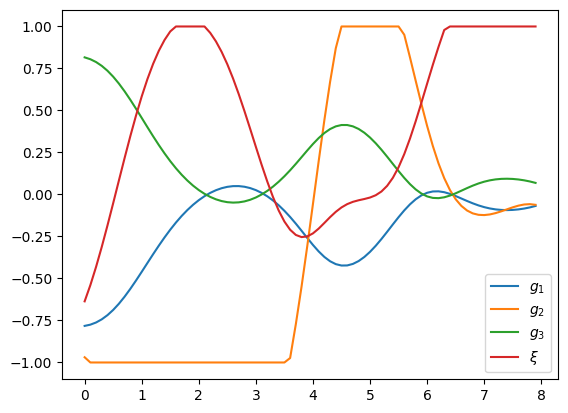

In [12]:
fig, ax = plt.subplots()

ax.plot(time, g1, label = r"$g_1$")
ax.plot(time, g2, label = r"$g_2$")
ax.plot(time, g3, label = r"$g_3$")
ax.plot(time, ξ, label = r"$\xi$")
ax.set_ylim(-1.1, 1.1)
ax.legend()

In [15]:
fidelities = torch.tensor([fidelity(partial_trace(get_density_matrix(state), [3]), target_state) for state in states])
fidelities[-1]

tensor(0.9749, dtype=torch.float64)

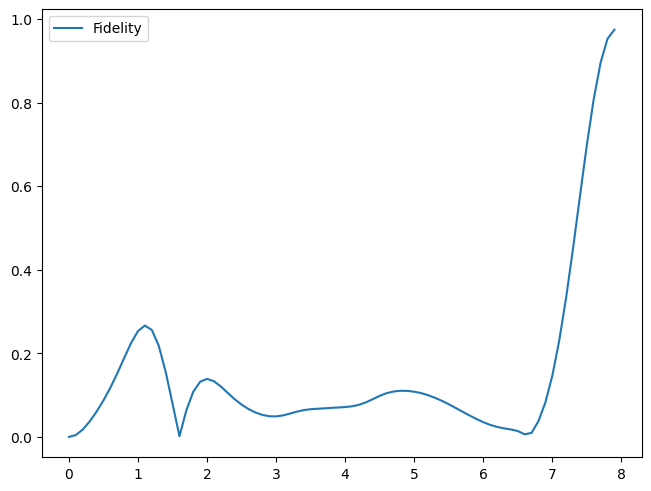

In [16]:
fig, ax = plt.subplots(layout='constrained')

ax.plot(time, fidelities, label=r"Fidelity")
ax.legend()